Connected to .venv (Python 3.10.14)

In [ ]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import math

In [ ]:
# Function to process images and return the image data, labels, and label-to-index mapping
def process_images_to_memory(folder_path, size=(475, 475)):
    images = []
    labels = []
    label_to_index = {}
    file_names_list = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".png"):
            # Process image
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGBA").resize(size)
            white_background = Image.new("RGBA", size, (255, 255, 255, 255))
            white_background.paste(image, (0, 0), image)

            # Convert to NumPy array and store
            images.append(np.array(white_background))

            # Remove the '.png' extension properly
            name = filename[:-4].lower()
            if name not in label_to_index:
                label_to_index[name] = len(label_to_index)  # Assign a unique index
            labels.append(name)
            file_names_list.append(name)  # Store filenames

    images = np.array(images, dtype=np.uint8)
    labels = np.array(labels, dtype="<U50")
    
    # Create index_to_label dictionary
    index_to_label = {i: file_names_list[i] for i in range(len(file_names_list))}
    print (index_to_label)
    print(label_to_index)
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    return images, labels, label_to_index, index_to_label

In [ ]:
# Define the custom dataset class

class PokemonDataset(Dataset):
    def __init__(self, images, labels, label_to_index, index_to_label, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.label_to_index = label_to_index
        self.index_to_label = index_to_label
        self.filenames = labels
        self.images = images
        self.labels = labels

        # Define augmentations pipeline if augment is enabled
        if self.augment:
            self.augmentation_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.RandomVerticalFlip(),  # Random vertical flip
            transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color parameters
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Apply random affine transformations
            transforms.RandomResizedCrop(475, scale=(0.8, 1.0)),  # Resize with random cropping
            transforms.GaussianBlur(kernel_size=3)  # Apply Gaussian blur for smoothness

        ])
        else:
            self.augmentation_transform = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert label to its corresponding index number
        label_idx = self.label_to_index[label]

        # Augment the image if specified
        if self.augment:
            image = Image.fromarray(image)
            image = self.augmentation_transform(image)  # Apply augmentation transformations
        else:
            image = Image.fromarray(image)

        # Apply additional transformations (e.g., normalization, resizing)
        if self.transform:
            image = self.transform(image)

        return image, label_idx

{0: 'abomasnow', 1: 'abra', 2: 'absol', 3: 'accelgor', 4: 'aegislash-shield', 5: 'aerodactyl', 6: 'aggron', 7: 'aipom', 8: 'alakazam', 9: 'alcremie', 10: 'alomomola', 11: 'altaria', 12: 'amaura', 13: 'ambipom', 14: 'amoonguss', 15: 'ampharos', 16: 'anorith', 17: 'appletun', 18: 'applin', 19: 'araquanid', 20: 'arbok', 21: 'arcanine', 22: 'arceus-normal', 23: 'archen', 24: 'archeops', 25: 'arctovish', 26: 'arctozolt', 27: 'ariados', 28: 'armaldo', 29: 'aromatisse', 30: 'aron', 31: 'arrokuda', 32: 'articuno', 33: 'audino', 34: 'aurorus', 35: 'avalugg', 36: 'axew', 37: 'azelf', 38: 'azumarill', 39: 'azurill'}
{'abomasnow': 0, 'abra': 1, 'absol': 2, 'accelgor': 3, 'aegislash-shield': 4, 'aerodactyl': 5, 'aggron': 6, 'aipom': 7, 'alakazam': 8, 'alcremie': 9, 'alomomola': 10, 'altaria': 11, 'amaura': 12, 'ambipom': 13, 'amoonguss': 14, 'ampharos': 15, 'anorith': 16, 'appletun': 17, 'applin': 18, 'araquanid': 19, 'arbok': 20, 'arcanine': 21, 'arceus-normal': 22, 'archen': 23, 'archeops': 24, '

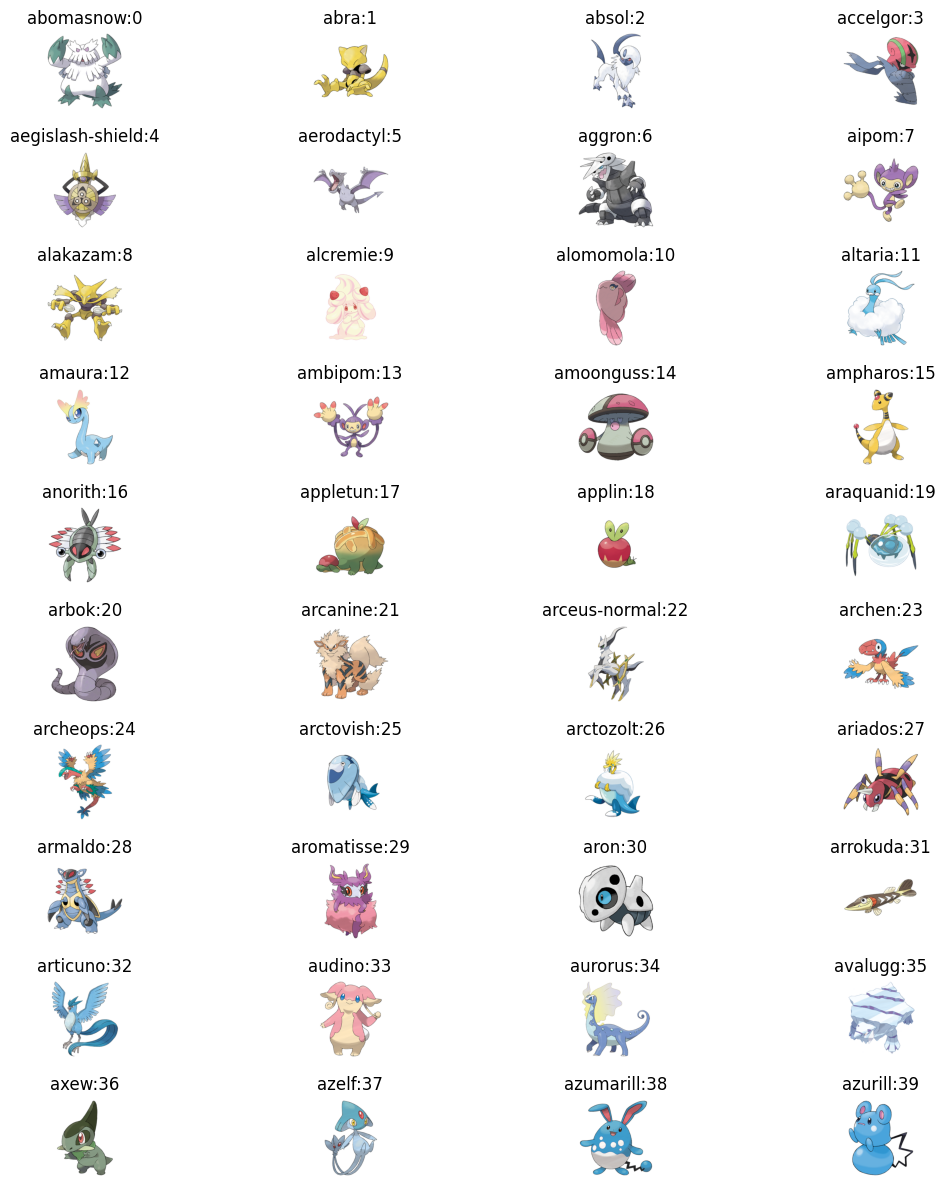

['abomasnow' 'abra' 'absol' 'accelgor' 'aegislash-shield' 'aerodactyl'
 'aggron' 'aipom' 'alakazam' 'alcremie' 'alomomola' 'altaria' 'amaura'
 'ambipom' 'amoonguss' 'ampharos' 'anorith' 'appletun' 'applin'
 'araquanid' 'arbok' 'arcanine' 'arceus-normal' 'archen' 'archeops'
 'arctovish' 'arctozolt' 'ariados' 'armaldo' 'aromatisse' 'aron'
 'arrokuda' 'articuno' 'audino' 'aurorus' 'avalugg' 'axew' 'azelf'
 'azumarill' 'azurill']


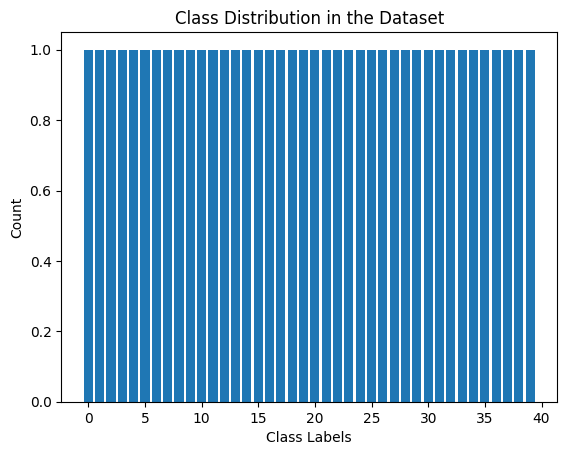

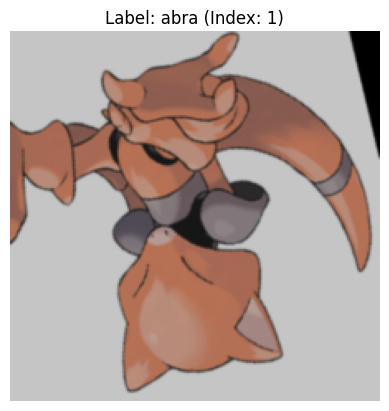

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset and create train, validation, and test sets
dataset_folder = '/home/viswam1@ds.vanderbilt.edu/Project_DS5660/dataset'  # Replace with your dataset path
images, labels, label_to_index, index_to_label = process_images_to_memory(dataset_folder)
test_labels = labels
test_labels_idx = label_to_index
test_idx_labels = index_to_label

# The images array needs to be reshaped to remove the alpha channel (RGBA)
images = images[:,:,:,0:3]  # Use only RGB channels
# Calculate the number of rows and columns needed for the grid
num_images = len(images)
cols = 4  # You can adjust the number of columns you want
rows = math.ceil(num_images / cols)

plt.figure(figsize=(12, 12))
for i in range(num_images):
    ax = plt.subplot(rows, cols, i + 1)  # Create a grid based on the number of images
    image = images[i]  # Convert tensor to numpy array (C,H,W -> H,W,C)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{labels[i]}:{label_to_index[labels[i]]}")

plt.tight_layout()
plt.show()

print(labels)
# Convert tensor to numpy for easier manipulation
labels_np = [label_to_index[label] for label in labels]

# Count occurrences of each class
unique, counts = np.unique(labels_np, return_counts=True)

# Plot class balance
plt.bar(unique, counts)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.show()

# Perform data augmentation (apply it to the entire dataset first)
augment_dataset = PokemonDataset(images, labels, label_to_index, index_to_label, transform=transform, augment=True)

train_loader = DataLoader(augment_dataset, batch_size=4, shuffle=True)

# Get a sample from the train loader to display
train_images_batch, train_labels_batch = next(iter(train_loader))

# Convert the image tensor back to a numpy array for display (from C x H x W to H x W x C)
image = train_images_batch[0].permute(1, 2, 0).numpy()  # Change from CHW to HWC format for display

# Since the image values are in [0, 1] after ToTensor(), we scale them to [0, 255]
image = (image * 255).astype(np.uint8)
# Get the label from the batch
label = train_labels_batch[0].item()  # Convert the tensor value to a native Python integer

# Convert label index to label name
label_name = index_to_label[label]

# Display the image
plt.imshow(image)
plt.title(f"Label: {label_name} (Index: {label})")  # Show both the label and the index
plt.axis('off')
plt.show()

In [ ]:
# Define the model (ResNet)
# Define the model (ResNet)

class PokemonClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(PokemonClassifier, self).__init__()
        
        # Load a pre-trained ResNet18 model or a fresh one
        self.model = models.resnet50(pretrained=True)
        
        # Modify the final fully connected layer to output the correct number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    
    def forward(self, x):
        # Pass through the ResNet layers
        x = self.model(x)
        
        
        return x

In [ ]:
# Initialize model, criterion, and optimizer and Training
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
num_classes = 40
model = PokemonClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Set learning rate


# Store training, validation, and testing losses for plotting
train_losses = []

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels= images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

/home/viswam1@ds.vanderbilt.edu/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viswam1@ds.vanderbilt.edu/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/150, Train Loss: 3.7880
Epoch 2/150, Train Loss: 3.7216
Epoch 3/150, Train Loss: 3.6692
Epoch 4/150, Train Loss: 3.6391
Epoch 5/150, Train Loss: 3.6104
Epoch 6/150, Train Loss: 3.5738
Epoch 7/150, Train Loss: 3.5274
Epoch 8/150, Train Loss: 3.5389
Epoch 9/150, Train Loss: 3.4675
Epoch 10/150, Train Loss: 3.4892
Epoch 11/150, Train Loss: 3.4279
Epoch 12/150, Train Loss: 3.4015
Epoch 13/150, Train Loss: 3.3479
Epoch 14/150, Train Loss: 3.3305
Epoch 15/150, Train Loss: 3.2996
Epoch 16/150, Train Loss: 3.3018
Epoch 17/150, Train Loss: 3.2646
Epoch 18/150, Train Loss: 3.1830
Epoch 19/150, Train Loss: 3.1710
Epoch 20/150, Train Loss: 3.1114
Epoch 21/150, Train Loss: 3.1168
Epoch 22/150, Train Loss: 3.0885
Epoch 23/150, Train Loss: 3.0531
Epoch 24/150, Train Loss: 3.0064
Epoch 25/150, Train Loss: 3.0032
Epoch 26/150, Train Loss: 2.9500
Epoch 27/150, Train Loss: 2.9030
Epoch 28/150, Train Loss: 2.8838
Epoch 29/150, Train Loss: 2.8906
Epoch 30/150, Train Loss: 2.7757
Epoch 31/150, Train

In [ ]:
torch.save(model, 'model_full.pth')

<ipython-input-8-b3431292fff7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_full.pth")


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39], device='cuda:6')
Test Accuracy: 100.00%


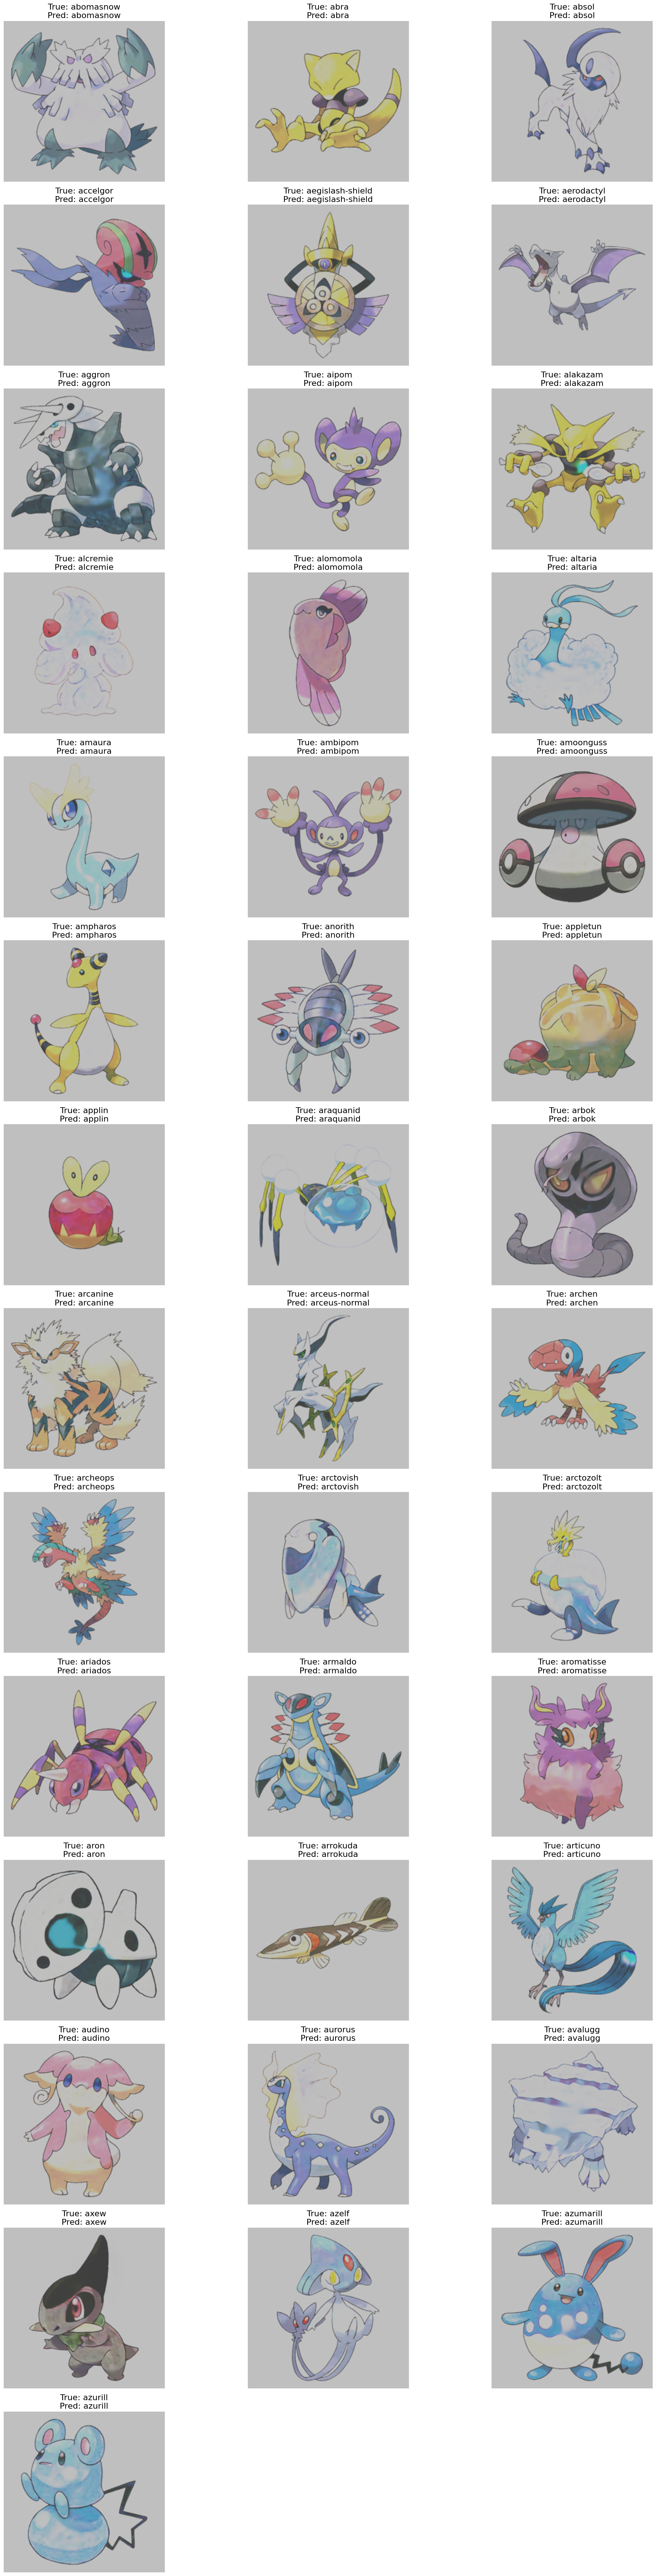

In [ ]:
# Test phase
model = torch.load("model_full.pth")
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

model.eval()
correct = 0
total = 0
folder_path = '/home/viswam1@ds.vanderbilt.edu/Project_DS5660/output_images'  # Replace with your dataset path
size=(475, 475)
images_test = []
for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".png"):
            # Process image
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("RGBA").resize(size)
            image = image.resize((224,224))
            images_test.append(np.array(image))

images_test = np.array(images_test, dtype=np.uint8)

# Add this code after testing phase or during the testing loop
def plot_test_batch(images, labels, predictions, index_to_label):
    """
    This function plots a batch of test images with their true and predicted labels.
    """
    # Convert indices to labels (convert tensors to integers)
    true_labels = [index_to_label[label.item()] for label in labels]  # Use .item() to get the integer value
    predicted_labels = [index_to_label[prediction.item()] for prediction in predictions]  # Use .item() to get the integer value

    # Calculate the number of rows and columns needed for the grid
    num_images = len(images)
    cols = 3  # You can adjust the number of columns you want
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(20, rows*5))
    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)  # Create a grid based on the number of images
        image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy array (C,H,W -> H,W,C)
        image = (image * 255).astype(np.uint8)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", fontsize=16)

    plt.tight_layout()
    plt.show()

# Testing loop with the batch plot
model.eval()
# Convert to PyTorch tensor, ensure it's the right shape

images_test = images_test[:,:,:,0:3]
images_test_tensor = torch.tensor(images_test).permute(0, 3, 1, 2).float()/255
images_test_batch = images_test_tensor.to(device)  # Move to device
labels_test =  np.arange(0,40,1)
# Get predictions
with torch.no_grad():
    outputs = model(images_test_batch)
    labels_test = torch.tensor(labels_test).to(device)
    _, predictions = torch.max(outputs, 1)
    total += labels_test.size(0)
    correct += (predictions == labels_test).sum().item()
    print(predictions)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot the test batch with true and predicted labels
plot_test_batch(images_test_batch, labels_test, predictions, test_idx_labels)